<a href="https://colab.research.google.com/github/pedrohortencio/text-generator/blob/main/Poetry%20Generator/Poetry_Generator_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!pip install gensim

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

!kaggle datasets download -d luxedo/machado-de-assis

!unzip /content/machado-de-assis.zip

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import regex as re

from gensim.models import KeyedVectors

import zipfile
import os
import urllib.request

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
data = open('/content/raw/txt/poesia/ocidentais.txt').read()
corpus1 = data.lower().split("\n")  # divide as poesias em linhas
corpus1 = corpus1[28:]    # Sem o índice

data = open('/content/raw/txt/poesia/crisalidas.txt').read()
corpus2 = data.lower().split("\n")
corpus2 = corpus2[34:2089]

data = open('/content/raw/txt/poesia/almada.txt').read()
corpus3 = data.lower().split("\n")
corpus3 = corpus3[100:2518]

data = open('/content/raw/txt/poesia/gazeta.txt').read()
corpus4 = data.lower().split("\n")
corpus4 = corpus4[4:4455]

corpus = corpus1 + corpus4 #+ corpus2 + corpus3     # concatena os corpus referentes a diferentes livros

In [18]:
#to_exclude = '"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t'

corpus = [text.replace("-", "") for text in corpus] # remove - das palavras: casou-se vira casouse

tokenizer = Tokenizer() # cria um tokenizer
tokenizer.fit_on_texts(corpus)  # treina o tokenizer no corpus

total_words = len(tokenizer.word_index) + 1
print("Total de palavras: ", len(tokenizer.word_index))

Total de palavras:  6965


In [19]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#### Célula apenas para exemplificar o funcionamento e lógica por trás da criação dos predictors e label

"""print("Frase para teste: ", '"Olá! O meu nome é Pedro"\n')
ls_test = []
for i in range(1, len(tokenizer.texts_to_sequences(["Olá! O meu nome é Pedro"])[0])):
    n_gram = tokenizer.texts_to_sequences(["Olá! O meu nome é Pedro"])[0][:i+1]

    ls_test.append(n_gram)
    print(f"{i}º engrama: \n {n_gram}")

max_sequence_len = max([len(x) for x in ls_test])
ls_test = np.array(pad_sequences(ls_test, maxlen=max_sequence_len, padding='pre'))
print("\nLista de n-gramas: \n", ls_test)

predictors, label = ls_test[:,:-1], ls_test[:,-1]
print("\nPredictors: \n", predictors)
print("\nLabels: \n", label)

label = ku.to_categorical(label, num_classes=total_words)

print("\nLabels depois do processo de one-hot-encoding: \n", label)"""

In [20]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    # Para cada linha no corpus, é criado uma sequência de inteiros que representa a frase
	token_list = tokenizer.texts_to_sequences([line])[0]

    # Cria n-grama da frase
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Criar duas variáveis: predictors e label
    # Predictors: conjunto de todos os n-gramas, mas sem a última palavra da frase
    # Label: ndarray com todas as últimas palavras de cada um dos n-gramas
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

# One-hot encoding na variável de labels
label = ku.to_categorical(label, num_classes=total_words)

[Repositório de Word Embeddings do NILC - USP](http://www.nilc.icmc.usp.br/embeddings)

In [7]:
#embedding_url = "http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s300.zip"
#embedding_url = 'http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip'
embedding_url = 'http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s100.zip'
#embedding_url = 'http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s100.zip'

In [8]:
_, _ = urllib.request.urlretrieve(embedding_url, filename="/content/word2vec.zip")

with zipfile.ZipFile('/content/word2vec.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/word2vec')

In [21]:
model = KeyedVectors.load_word2vec_format('/content/word2vec/cbow_s100.txt')

In [22]:
embedding_weights = np.zeros((total_words, 100))
for word, index in tokenizer.word_index.items():
    try:
        embedding_weights[index, :] = model[word]
    except KeyError:
        pass

In [23]:
with open('embedding-weights.pickle', 'wb') as handle:
    pickle.dump(embedding_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
from keras.layers import Flatten, LeakyReLU

In [81]:
model = Sequential()

model.add(Embedding(total_words, 100, weights = [embedding_weights], input_length = max_sequence_len-1, trainable=False))

model.add(Bidirectional(LSTM(256, return_sequences = True)))
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(100))
model.add(LeakyReLU(alpha=0.2))

model.add(Dense(total_words, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 11, 100)           696600    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 11, 512)           731136    
_________________________________________________________________
flatten_13 (Flatten)         (None, 5632)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 100)               563300    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 6966)              703566    
Total params: 2,694,602
Trainable params: 1,998,002
Non-trainable params: 696,600
_____________________________________

In [82]:
history = model.fit(predictors, label, batch_size=64, epochs=50) 

Epoch 1/50
345/345 [==============================] - 10s 18ms/step - loss: 7.7863 - accuracy: 0.0393
Epoch 2/50
345/345 [==============================] - 6s 17ms/step - loss: 6.8070 - accuracy: 0.0772
Epoch 3/50
345/345 [==============================] - 6s 17ms/step - loss: 6.2235 - accuracy: 0.0922
Epoch 4/50
345/345 [==============================] - 6s 17ms/step - loss: 5.6200 - accuracy: 0.1030
Epoch 5/50
345/345 [==============================] - 6s 17ms/step - loss: 5.0313 - accuracy: 0.1176
Epoch 6/50
345/345 [==============================] - 6s 17ms/step - loss: 4.4255 - accuracy: 0.1588
Epoch 7/50
345/345 [==============================] - 6s 17ms/step - loss: 3.8345 - accuracy: 0.2294
Epoch 8/50
345/345 [==============================] - 6s 17ms/step - loss: 3.3740 - accuracy: 0.3021
Epoch 9/50
345/345 [==============================] - 6s 17ms/step - loss: 2.9814 - accuracy: 0.3682
Epoch 10/50
345/345 [==============================] - 6s 17ms/step - loss: 2.7368 - accur

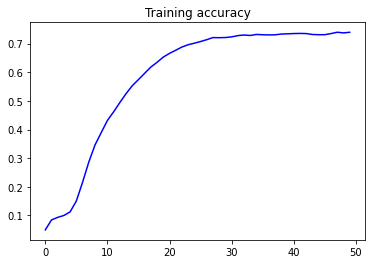

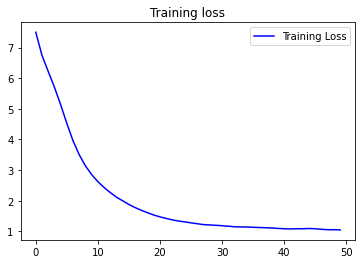

In [83]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [85]:
model.save('/content/model')

INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


In [86]:
!zip -r /content/model-poetry-generator-ptbrV2.02.25041118.zip /content/model

updating: content/model/ (stored 0%)
updating: content/model/variables/ (stored 0%)
updating: content/model/variables/variables.index (deflated 65%)
updating: content/model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: content/model/saved_model.pb (deflated 89%)
updating: content/model/assets/ (stored 0%)


In [87]:
model.save_weights('poetry-generator-ptbrV2.02.25041118.h5')

In [84]:
#seed_text = "Minha alma"
#seed_text = 'Nenhuma quantidade de liberdade pode limpar'
#seed_text = 'Água mole em pedra dura'
seed_text = 'Os olhos dela brilhavam como o sol'

next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    #predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

seed_text = seed_text.replace(" .", ".").replace(" ,", ",").replace(" !", "!").replace(" ?", "?").replace(" :", ":")

print(seed_text)

Os olhos dela brilhavam como o sol caída para eterna morte ou mestre amigo o sol que pimenta mil e mesmo de lá não se de amigo e de tal e triste de mistério de folhas que de ela adverso de de um de que de um o de outro ” triste vagalume vivo vagalume mudo canto e tudo — que me dera o inferno ou a rua de ela que de vida que nada de um de ou sem de poltrona e ela se que meninas e o mais que há de de o de a de de outra lady e repente cantiga triste que outro


[Pretrained Word Embeddings](https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/)